### Test the trained VPTR

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

from pathlib import Path
import random
from datetime import datetime
import time

from model import VPTREnc, VPTRDec, VPTRDisc, init_weights, VPTRFormerFAR, VPTRFormerNAR
from model import GDL, MSELoss, L1Loss, GANLoss
from utils import KTHDataset, BAIRDataset, MovingMNISTDataset
from utils import VidCenterCrop, VidPad, VidResize, VidNormalize, VidReNormalize, VidCrop, VidRandomHorizontalFlip, VidRandomVerticalFlip, VidToTensor
from utils import visualize_batch_clips, save_ckpt, load_ckpt, set_seed, AverageMeters, init_loss_dict, write_summary, resume_training, write_code_files
from utils import set_seed, PSNR, SSIM, MSEScore, get_dataloader
import lpips
import numpy as np


from matplotlib import pyplot as plt

set_seed(2021)
torch.has_mps

True

In [2]:
resume_ckpt = Path('./MovingMNIST_NAR.tar') #The trained Transformer checkpoint file
resume_AE_ckpt = Path('./MovingMNIST_AE.tar') #The trained AutoEncoder checkpoint file
num_past_frames = 10
num_future_frames = 10
encH, encW, encC = 8, 8, 528
TSLMA_flag = False
rpe = True
model_flag = 'NAR' #'NAR' for NAR model, 'FAR' for FAR model

img_channels = 1 # 1 for KTH and MovingMNIST, 3 for BAIR
N = 16
device = torch.device('cuda:0'') #mps
loss_name_list = ['T_MSE', 'T_GDL', 'T_gan', 'T_total', 'Dtotal', 'Dfake', 'Dreal']

In [3]:
#Set the padding_type to be "zero" for BAIR dataset
VPTR_Enc = VPTREnc(img_channels, feat_dim = encC, n_downsampling = 3, padding_type = 'reflect').to(device) 

#Set the padding_type to be "zero" for BAIR dataset, set the out_layer to be 'Sigmoid' for MovingMNIST
VPTR_Dec = VPTRDec(img_channels, feat_dim = encC, n_downsampling = 3, out_layer = 'Sigmoid', padding_type = 'reflect').to(device) 
VPTR_Enc = VPTR_Enc.eval()
VPTR_Dec = VPTR_Dec.eval()

if model_flag == 'NAR':
    VPTR_Transformer = VPTRFormerNAR(num_past_frames, num_future_frames, encH=encH, encW = encW, d_model=encC, 
                                         nhead=8, num_encoder_layers=4, num_decoder_layers=8, dropout=0.1, 
                                         window_size=4, Spatial_FFN_hidden_ratio=4, TSLMA_flag = TSLMA_flag, rpe=rpe).to(device)
else:
    VPTR_Transformer = VPTRFormerFAR(num_past_frames, num_future_frames, encH=encH, encW = encW, d_model=encC, 
                                    nhead=8, num_encoder_layers=12, dropout=0.1, 
                                    window_size=4, Spatial_FFN_hidden_ratio=4, rpe=rpe).to(device)

VPTR_Transformer = VPTR_Transformer.eval()

#load the trained autoencoder, we initialize the discriminator from scratch, for a balanced training
loss_dict, start_epoch = resume_training({'VPTR_Enc': VPTR_Enc, 'VPTR_Dec': VPTR_Dec}, {}, resume_AE_ckpt, loss_name_list, map_location = torch.device("cpu"))
if resume_ckpt is not None:
    loss_dict, start_epoch = resume_training({'VPTR_Transformer': VPTR_Transformer}, 
                                             {}, resume_ckpt, loss_name_list, map_location = torch.device("cpu"))

/opt/homebrew/Caskroom/miniforge/base/lib/python3.10/site-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /Users/runner/miniforge3/conda-bld/pytorch-recipe_1664817728005/work/aten/src/ATen/native/TensorShape.cpp:2895.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/Users/lrob/Desktop/4Y/Prelim/VPTR/utils/position_encoding.py:39: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / E)
/Users/lrob/Desktop/4Y/Prelim/VPTR/utils/position_encoding.py:77: UserWarning: The operator 'aten::

_, _, test_loader, renorm_transform = get_dataloader('MNIST', N, './MovingMNIST', test_past_frames = 10, test_future_frames = 10, ngpus = 1, num_workers = 1)

In [17]:
def plot_model_result(pred, fig_name, num_frames, n = 2):
    """
    Plot and save figure
    """
    fig, ax = plt.subplots(1, num_frames, figsize = (num_frames, 1))
    fig.subplots_adjust(wspace=0., hspace = 0.)

    for j in range(num_frames):
        ax[j].set_axis_off()
        
        img = pred[:, j, :, :, :].clone()
        img = renorm_transform(img)
        img = torch.clamp(img, min = 0., max = 1.)
        img = img[n, ...]

        img = transforms.ToPILImage()(img)
        ax[j].imshow(img, cmap = 'gray')
    fig.savefig(f'{fig_name}.pdf', bbox_inches = 'tight')
    
def FAR_RIL_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    recurrently inference over Latent space, get a worse result
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"

    past_gt_feats = VPTR_Enc(past_frames)
    pred_feats = VPTR_Transformer(past_gt_feats)
    
    pred_frames = VPTR_Dec(pred_feats[:, -1:, ...])
    for i in range(1, num_pred):
        if i == 1:
            input_feats = torch.cat([past_gt_feats, pred_feats[:, -1:, ...]], dim = 1)
        elif i < VPTR_Transformer.num_future_frames:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
        else:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
            input_feats = input_feats[:, 1:, ...]
        
        pred_feats = VPTR_Transformer(input_feats)
        pred_future_frame = VPTR_Dec(pred_feats[:, -1:, ...])
        pred_future_feat = pred_feats[:, -1:, ...]
        pred_frames = torch.cat([pred_frames, pred_future_frame], dim = 1)
    
    return pred_frames, future_frames

def FAR_RIP_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    recurrently inference over pixel space
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"

    past_gt_feats = VPTR_Enc(past_frames)
    pred_feats = VPTR_Transformer(past_gt_feats)
    
    pred_frames = VPTR_Dec(pred_feats[:, -1:, ...])
    for i in range(1, num_pred):
        if i == 1:
            input_feats = torch.cat([past_gt_feats, pred_feats[:, -1:, ...]], dim = 1)
        elif i < VPTR_Transformer.num_future_frames:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
        else:
            input_feats = torch.cat([input_feats, pred_future_feat], dim = 1)
            input_feats = input_feats[:, 1:, ...]
        
        pred_feats = VPTR_Transformer(input_feats)
        pred_future_frame = VPTR_Dec(pred_feats[:, -1:, ...])
        pred_future_feat = VPTR_Enc(pred_future_frame)
        pred_frames = torch.cat([pred_frames, pred_future_frame], dim = 1)
    
    return pred_frames, future_frames

def NAR_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    NAR model inference function, for the case num_pred is divisible for the num_future_frames of training. e.g. num_pred = 20, num_future_frames = 10
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"
    assert num_pred % VPTR_Transformer.num_future_frames == 0, "Mismatch of num_pred and trained Transformer"
    
    past_gt_feats = VPTR_Enc(past_frames)
    
    for i in range(0, num_pred//VPTR_Transformer.num_future_frames):
        pred_future_feats = VPTR_Transformer(past_gt_feats)
        if i == 0:
            pred_frames = VPTR_Dec(pred_future_feats)
        else:
            pred_frames = torch.cat([pred_frames, VPTR_Dec(pred_future_feats)], dim = 1)
        past_gt_feats = pred_future_feats
        
    
    return pred_frames, future_frames


def NAR_BAIR_2_to_28_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device):
    """
    Specifically for BAIR dataset, 2 -> 28 prediction.
    """
    past_frames, future_frames = sample
    past_frames = past_frames.to(device)
    future_frames = future_frames.to(device)
    assert num_pred == future_frames.shape[1], "Mismatch between ground truth future frames length and num_pred"
    #assert num_pred % VPTR_Transformer.num_future_frames == 0, "Mismatch of num_pred and trained Transformer"
    
    pred = []
    #prediction 1
    past_gt_feats = VPTR_Enc(past_frames)
    pred_future_feats = VPTR_Transformer(past_gt_feats)
    pred_frames = VPTR_Dec(pred_future_feats)
    pred.append(pred_frames)
    #prediction 2
    past_frames = pred_frames[:, -2:, ...]
    past_gt_feats = VPTR_Enc(past_frames)
    pred_future_feats = VPTR_Transformer(past_gt_feats)
    pred_frames = VPTR_Dec(pred_future_feats)
    pred.append(pred_frames)
    
    #prediction 3
    past_frames = pred_frames[:, -2:, ...]
    past_gt_feats = VPTR_Enc(past_frames)
    pred_future_feats = VPTR_Transformer(past_gt_feats)
    pred_frames = VPTR_Dec(pred_future_feats)
    pred.append(pred_frames[:, 0:-2, ...])
    pred_frames = torch.cat(pred, dim = 1)
    
    return pred_frames, future_frames         

In [16]:
from torchvision import models
from torchinfo import summary

summary(VPTR_Transformer, input_feats)

NameError: name 'input_feats' is not defined

In [20]:
sample = next(iter(test_loader))

num_pred = 10
with torch.no_grad():
    pred_frames, gt_frames = NAR_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device)


torch.Size([16, 10, 1, 64, 64])
torch.Size([16, 10, 1, 64, 64])
torch.Size([16, 10, 8, 8, 528])
torch.Size([16, 10, 8, 8, 528])
torch.Size([16, 10, 8, 8, 528])
torch.Size([16, 10, 8, 8, 528])


In [21]:
sample = next(iter(test_loader))
num_pred = 10
with torch.no_grad():
    pred_frames, gt_frames = NAR_test_single_iter(sample, VPTR_Enc, VPTR_Dec, VPTR_Transformer, num_pred, device)


torch.Size([16, 10, 8, 8, 528])
torch.Size([16, 10, 8, 8, 528])
torch.Size([16, 10, 8, 8, 528])
torch.Size([16, 10, 8, 8, 528])
torch.Size([16, 10, 1, 64, 64])


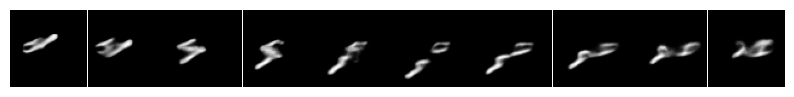

In [34]:
plot_model_result(pred_frames, 'pred_nar_mnist', 10, n = 6)

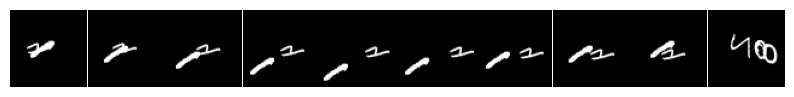

In [35]:
plot_model_result(gt_frames, 'gt_mnist', 10, n = 6)

In [36]:
import numpy as np
from utils import PSNR, SSIM
import lpips

def pred_ave_metrics(model, data_loader, metric_func, renorm_transform, num_future_frames, num_past_frames, device = 'cuda:0', use_lpips = False, gray_scale = True):
    model = model.to(device)
    model = model.eval()
    ave_metric = np.zeros(num_future_frames)
    sample_num = 0

    with torch.no_grad():
        for idx, sample in enumerate(data_loader, 0):
            past_frames, future_frames = sample
            past_frames = past_frames.to(device)
            future_frames = future_frames.to(device)
            pred = model(past_frames)
            for i in range(0, num_future_frames):
                pred_t = pred[:, i, ...]
                future_frames_t = future_frames[:, i, ...]
                
                if not use_lpips:
                    pred_t = renorm_transform(pred_t)
                    future_frames_t = renorm_transform(future_frames_t)
                elif use_lpips and gray_scale:
                    pred_t = pred_t.repeat(1, 3, 1, 1)
                    future_frames_t = future_frames_t.repeat(1, 3, 1, 1)
                    
                m = metric_func(pred_t, future_frames_t)*pred_t.shape[0]
                try:
                    ave_metric[i] += m.mean()
                except AttributeError:
                    ave_metric[i] += m
                
            sample_num += pred.shape[0]

    ave_metric = ave_metric / sample_num
    return ave_metric

In [ ]:
pre_ave_metrics